# Notebook 04: Model Development & Optimization

Advanced model development, hyperparameter tuning, and performance optimization using the feature engineered dataset from Notebook 03.

## Objectives:
1. Load and verify feature engineered data from Notebook 03
2. Develop baseline models for comparison
3. Implement advanced regression models (Random Forest, XGBoost, etc.)
4. Perform hyperparameter optimization
5. Ensemble methods and model stacking
6. Final model evaluation and selection

In [14]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, clone

# Advanced Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Optimization
import optuna
from optuna.pruners import MedianPruner

# Progress tracking and utilities
from tqdm import tqdm
import joblib
import time
from scipy.optimize import minimize

# Set random seeds
np.random.seed(42)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [15]:
# Load processed datasets
X_train = pd.read_csv('../data/processed/X_train_final.csv')
X_test = pd.read_csv('../data/processed/X_test_final.csv')
target_data = pd.read_csv('../data/processed/y_train_final.csv')

print("\n" + "="*60)
print("Data Import Summary:")
print(f"Features available: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print("="*60)

# Extract log-transformed target
y_log = target_data['SalePrice']

print(f"\nTarget Variable Statistics:")
print(f"  Shape: {y_log.shape}")
print(f"  Mean: {y_log.mean():.4f}")
print(f"  Std: {y_log.std():.4f}")
print(f"  Range: {y_log.min():.4f} - {y_log.max():.4f}")

# Data quality validation
print("\nData Quality Check:")
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in target: {y_log.isnull().sum()}")

# Handle infinite values
inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()

print(f"Infinite values in X_train: {inf_train}")
print(f"Infinite values in X_test: {inf_test}")

if inf_test > 0:
    print("Handling infinite values in test data...")
    inf_cols = X_test.columns[np.isinf(X_test).any()]
    for col in inf_cols:
        if col in X_train.columns:
            replacement_value = X_train[col].median()
            X_test[col] = X_test[col].replace([np.inf, -np.inf], replacement_value)
            print(f"  {col}: replaced with training median {replacement_value:.4f}")
    print("Infinite values handled")

print("Data loading complete")


Data Import Summary:
Features available: 190
Training samples: 1458
Test samples: 1459

Target Variable Statistics:
  Shape: (1458,)
  Mean: 12.0240
  Std: 0.3997
  Range: 10.4602 - 13.5345

Data Quality Check:
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in target: 0
Infinite values in X_train: 0
Infinite values in X_test: 0
Data loading complete


In [16]:
# Create train-validation split
X_train_split, X_val, y_train, y_val = train_test_split(
    X_train, y_log, 
    test_size=0.2, 
    random_state=42
)

print(f"\nData Split Summary:")
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
print("Cross-validation configured: 5-fold")


Data Split Summary:
Training set: (1166, 190)
Validation set: (292, 190)
Test set: (1459, 190)
Cross-validation configured: 5-fold


In [17]:
def evaluate_model(model, X, y, cv_folds, model_name="Model"):
    """
    Evaluate model using cross-validation and validation set
    """
    print(f"Evaluating {model_name}...")
    
    # Cross-validation scores
    cv_scores = []
    with tqdm(total=cv_folds.n_splits, desc=f"CV {model_name}", leave=False) as pbar:
        for train_idx, val_idx in cv_folds.split(X, y):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Fit and predict
            model_copy = clone(model)
            model_copy.fit(X_fold_train, y_fold_train)
            pred = model_copy.predict(X_fold_val)
            
            # Calculate RMSE for this fold
            fold_rmse = np.sqrt(mean_squared_error(y_fold_val, pred))
            cv_scores.append(fold_rmse)
            
            pbar.update(1)
    
    cv_rmse = np.array(cv_scores)
    
    # Validation set score
    model.fit(X, y)
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    return {
        'model_name': model_name,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std(),
        'val_rmse': val_rmse
    }

print("Model evaluation function ready")

Model evaluation function ready


In [18]:
# Define seven diverse baseline models
baseline_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.01, random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=2000),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)
}

print("\nBaseline Model Performance:")
print("=" * 75)
print(f"{'Model':<15} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12}")
print("-" * 75)

baseline_results = {}
total_models = len(baseline_models)

with tqdm(total=total_models, desc="Baseline Models") as pbar:
    for name, model in baseline_models.items():
        pbar.set_description(f"Training {name}")
        
        try:
            result = evaluate_model(model, X_train_split, y_train, cv, name)
            baseline_results[name] = result
            
            print(f"{name:<15} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} "
                  f"{result['val_rmse']:<12.4f}")
        except Exception as e:
            print(f"{name:<15} FAILED: {str(e)[:50]}")
            baseline_results[name] = {
                'cv_rmse_mean': float('inf'), 
                'cv_rmse_std': 0, 
                'val_rmse': float('inf')
            }
        
        pbar.update(1)

print("-" * 75)

# Find best baseline model
valid_results = {k: v for k, v in baseline_results.items() if v['cv_rmse_mean'] != float('inf')}
if valid_results:
    best_baseline = min(valid_results.items(), key=lambda x: x[1]['cv_rmse_mean'])
    print(f"Best baseline model: {best_baseline[0]} (CV RMSE: {best_baseline[1]['cv_rmse_mean']:.4f})")
else:
    print("Warning: No baseline models succeeded")


Baseline Model Performance:
Model           CV RMSE      CV Std     Val RMSE    
---------------------------------------------------------------------------


Training Ridge:   0%|          | 0/7 [00:00<?, ?it/s] 

Evaluating Ridge...


Training Lasso:  14%|█▍        | 1/7 [00:00<00:00, 35.85it/s]

Ridge           0.1219       0.0089     0.1201      
Evaluating Lasso...


Training ElasticNet:  29%|██▊       | 2/7 [00:00<00:00, 14.48it/s]

Lasso           0.1454       0.0067     0.1488      
Evaluating ElasticNet...


Training RandomForest:  43%|████▎     | 3/7 [00:00<00:00, 14.48it/s]

ElasticNet      0.1366       0.0081     0.1389      
Evaluating RandomForest...


Training GradientBoosting:  57%|█████▋    | 4/7 [00:01<00:01,  2.92it/s]

RandomForest    0.1415       0.0106     0.1468      
Evaluating GradientBoosting...


Training XGBoost:  71%|███████▏  | 5/7 [00:03<00:01,  1.28it/s]         

GradientBoosting 0.1279       0.0097     0.1285      
Evaluating XGBoost...


Training LightGBM:  86%|████████▌ | 6/7 [00:04<00:00,  1.16it/s]

XGBoost         0.1378       0.0093     0.1473      
Evaluating LightGBM...


Training LightGBM: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

LightGBM        0.1297       0.0089     0.1341      
---------------------------------------------------------------------------
Best baseline model: Ridge (CV RMSE: 0.1219)


In [19]:
class OptunaTqdmCallback:
    """Custom callback for Optuna to show progress with tqdm"""
    def __init__(self, n_trials, model_name):
        self.n_trials = n_trials
        self.model_name = model_name
        self.pbar = None
    
    def __call__(self, study, trial):
        if self.pbar is None:
            self.pbar = tqdm(total=self.n_trials, desc=f"Optimizing {self.model_name}")
        
        self.pbar.set_postfix({
            'Trial': trial.number + 1,
            'Best': f"{study.best_value:.4f}" if study.best_value else "N/A"
        })
        self.pbar.update(1)
        
        if trial.number + 1 >= self.n_trials:
            self.pbar.close()

print("Optuna callback configured")

Optuna callback configured


In [20]:
def objective_xgb(trial):
    """Objective function for XGBoost hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_optimization',
                               pruner=MedianPruner(n_startup_trials=10))
n_trials_xgb = 75
callback_xgb = OptunaTqdmCallback(n_trials_xgb, "XGBoost")
study_xgb.optimize(objective_xgb, n_trials=n_trials_xgb, callbacks=[callback_xgb])

print(f"Best XGBoost RMSE: {study_xgb.best_value:.4f}")
best_xgb_params = study_xgb.best_params
best_xgb = XGBRegressor(**best_xgb_params, random_state=42, verbosity=0)
xgb_result = evaluate_model(best_xgb, X_train_split, y_train, cv, "XGBoost_Optimized")

[I 2025-07-14 09:47:11,770] A new study created in memory with name: xgb_optimization


Optimizing XGBoost...


[I 2025-07-14 09:47:13,503] Trial 0 finished with value: 0.14264049184210173 and parameters: {'n_estimators': 661, 'max_depth': 7, 'learning_rate': 0.2948447418942032, 'subsample': 0.7105768040088728, 'colsample_bytree': 0.6995037606292803, 'min_child_weight': 4}. Best is trial 0 with value: 0.14264049184210173.
Optimizing XGBoost: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s, Trial=75, Best=0.1187]


Best XGBoost RMSE: 0.1187
Evaluating XGBoost_Optimized...


In [21]:
def objective_catboost(trial):
    """Objective function for CatBoost hyperparameter optimization"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing CatBoost...")
study_catboost = optuna.create_study(direction='minimize', study_name='catboost_optimization',
                                    pruner=MedianPruner(n_startup_trials=10))
n_trials_catboost = 75
callback_catboost = OptunaTqdmCallback(n_trials_catboost, "CatBoost")
study_catboost.optimize(objective_catboost, n_trials=n_trials_catboost, callbacks=[callback_catboost])

print(f"Best CatBoost RMSE: {study_catboost.best_value:.4f}")
best_catboost_params = study_catboost.best_params
best_catboost = CatBoostRegressor(**best_catboost_params, random_seed=42, verbose=False)
catboost_result = evaluate_model(best_catboost, X_train_split, y_train, cv, "CatBoost_Optimized")

[I 2025-07-14 09:47:57,304] A new study created in memory with name: catboost_optimization


Optimizing CatBoost...


[I 2025-07-14 09:47:57,865] Trial 0 finished with value: 0.12573624564146613 and parameters: {'iterations': 152, 'depth': 4, 'learning_rate': 0.06419767564223734, 'l2_leaf_reg': 4.758353740238038}. Best is trial 0 with value: 0.12573624564146613.
Optimizing CatBoost: 100%|██████████| 75/75 [02:38<00:00,  2.11s/it, Trial=75, Best=0.1149]


Best CatBoost RMSE: 0.1149
Evaluating CatBoost_Optimized...


In [22]:
def objective_lgbm(trial):
    """Objective function for LightGBM hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'verbosity': -1
    }
    
    model = LGBMRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing LightGBM...")
study_lgbm = optuna.create_study(direction='minimize', study_name='lgbm_optimization',
                                pruner=MedianPruner(n_startup_trials=10))
n_trials_lgbm = 75
callback_lgbm = OptunaTqdmCallback(n_trials_lgbm, "LightGBM")
study_lgbm.optimize(objective_lgbm, n_trials=n_trials_lgbm, callbacks=[callback_lgbm])

print(f"Best LightGBM RMSE: {study_lgbm.best_value:.4f}")
best_lgbm_params = study_lgbm.best_params
best_lgbm = LGBMRegressor(**best_lgbm_params, random_state=42, verbosity=-1)
lgbm_result = evaluate_model(best_lgbm, X_train_split, y_train, cv, "LightGBM_Optimized")

[I 2025-07-14 09:50:39,314] A new study created in memory with name: lgbm_optimization


Optimizing LightGBM...


[I 2025-07-14 09:50:40,560] Trial 0 finished with value: 0.16516931186645506 and parameters: {'n_estimators': 985, 'max_depth': 10, 'learning_rate': 0.09054311123858225, 'subsample': 0.6459709501584275, 'colsample_bytree': 0.6234944571052636, 'min_child_samples': 47, 'reg_alpha': 9.044007144086155, 'reg_lambda': 9.752288454580984}. Best is trial 0 with value: 0.16516931186645506.
Optimizing LightGBM: 100%|██████████| 75/75 [03:34<00:00,  2.87s/it, Trial=75, Best=0.1262]


Best LightGBM RMSE: 0.1262
Evaluating LightGBM_Optimized...


In [23]:
def objective_rf(trial):
    """Objective function for RandomForest hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing RandomForest...")
study_rf = optuna.create_study(direction='minimize', study_name='rf_optimization')
n_trials_rf = 50
callback_rf = OptunaTqdmCallback(n_trials_rf, "RandomForest")
study_rf.optimize(objective_rf, n_trials=n_trials_rf, callbacks=[callback_rf])

print(f"Best RandomForest RMSE: {study_rf.best_value:.4f}")
best_rf_params = study_rf.best_params
best_rf = RandomForestRegressor(**best_rf_params, random_state=42, n_jobs=-1)
rf_result = evaluate_model(best_rf, X_train_split, y_train, cv, "RandomForest_Optimized")

[I 2025-07-14 09:54:29,496] A new study created in memory with name: rf_optimization


Optimizing RandomForest...


[I 2025-07-14 09:54:30,146] Trial 0 finished with value: 0.16007267988404725 and parameters: {'n_estimators': 466, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.16007267988404725.
Optimizing RandomForest: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s, Trial=50, Best=0.1415]


Best RandomForest RMSE: 0.1415
Evaluating RandomForest_Optimized...


In [24]:
def objective_lasso(trial):
    """Objective function for Lasso hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    model = Lasso(alpha=alpha, random_state=42, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing Lasso...")
study_lasso = optuna.create_study(direction='minimize', study_name='lasso_optimization')
n_trials_lasso = 30
callback_lasso = OptunaTqdmCallback(n_trials_lasso, "Lasso")
study_lasso.optimize(objective_lasso, n_trials=n_trials_lasso, callbacks=[callback_lasso])

print(f"Best Lasso RMSE: {study_lasso.best_value:.4f}")
best_lasso_params = study_lasso.best_params
best_lasso = Lasso(**best_lasso_params, random_state=42, max_iter=3000)
lasso_result = evaluate_model(best_lasso, X_train_split, y_train, cv, "Lasso_Optimized")

[I 2025-07-14 09:55:16,769] A new study created in memory with name: lasso_optimization
[I 2025-07-14 09:55:16,896] Trial 0 finished with value: 0.21204913482698123 and parameters: {'alpha': 0.09007074907083933}. Best is trial 0 with value: 0.21204913482698123.


Optimizing Lasso...


Optimizing Lasso: 100%|██████████| 30/30 [00:05<00:00,  5.07it/s, Trial=30, Best=0.1180]


Best Lasso RMSE: 0.1180
Evaluating Lasso_Optimized...


In [25]:
def objective_elasticnet(trial):
    """Objective function for ElasticNet hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing ElasticNet...")
study_elasticnet = optuna.create_study(direction='minimize', study_name='elasticnet_optimization')
n_trials_elasticnet = 30
callback_elasticnet = OptunaTqdmCallback(n_trials_elasticnet, "ElasticNet")
study_elasticnet.optimize(objective_elasticnet, n_trials=n_trials_elasticnet, callbacks=[callback_elasticnet])

print(f"Best ElasticNet RMSE: {study_elasticnet.best_value:.4f}")
best_elasticnet_params = study_elasticnet.best_params
best_elasticnet = ElasticNet(**best_elasticnet_params, random_state=42, max_iter=3000)
elasticnet_result = evaluate_model(best_elasticnet, X_train_split, y_train, cv, "ElasticNet_Optimized")

[I 2025-07-14 09:55:23,199] A new study created in memory with name: elasticnet_optimization
[I 2025-07-14 09:55:23,331] Trial 0 finished with value: 0.1923283305823489 and parameters: {'alpha': 0.05789103122654102, 'l1_ratio': 0.8479743560569344}. Best is trial 0 with value: 0.1923283305823489.


Optimizing ElasticNet...


Optimizing ElasticNet: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s, Trial=30, Best=0.1188]


Best ElasticNet RMSE: 0.1188
Evaluating ElasticNet_Optimized...


In [26]:
# Compile all optimization results
optimized_results = {
    'XGBoost': xgb_result,
    'CatBoost': catboost_result,
    'LightGBM': lgbm_result,
    'RandomForest': rf_result,
    'Lasso': lasso_result,
    'ElasticNet': elasticnet_result
}

print("\n" + "="*85)
print("HYPERPARAMETER OPTIMIZATION RESULTS")
print("="*85)
print(f"{'Model':<15} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12} {'Improvement':<12}")
print("-"*85)

baseline_cv_rmse = best_baseline[1]['cv_rmse_mean'] if 'best_baseline' in locals() else float('inf')

for name, result in sorted(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    if baseline_cv_rmse != float('inf'):
        improvement = (baseline_cv_rmse - result['cv_rmse_mean']) / baseline_cv_rmse * 100
    else:
        improvement = 0
    
    print(f"{name:<15} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} "
          f"{result['val_rmse']:<12.4f} {improvement:<12.2f}%")

best_individual = min(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean'])
print(f"\nBest individual model: {best_individual[0]} (CV RMSE: {best_individual[1]['cv_rmse_mean']:.4f})")


HYPERPARAMETER OPTIMIZATION RESULTS
Model           CV RMSE      CV Std     Val RMSE     Improvement 
-------------------------------------------------------------------------------------
CatBoost        0.1145       0.0100     0.1280       6.09        %
Lasso           0.1178       0.0079     0.1204       3.40        %
XGBoost         0.1182       0.0114     0.1227       3.04        %
ElasticNet      0.1185       0.0084     0.1213       2.77        %
LightGBM        0.1258       0.0112     0.1337       -3.16       %
RandomForest    0.1411       0.0108     0.1449       -15.72      %

Best individual model: CatBoost (CV RMSE: 0.1145)


In [27]:
# Select top 3 models for ensemble methods
top_models = sorted(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[:3]
print(f"\nTop 3 models selected for ensembles:")
for i, (name, result) in enumerate(top_models, 1):
    print(f"  {i}. {name}: {result['cv_rmse_mean']:.4f}")

# Get model objects
model_map = {
    'XGBoost': best_xgb,
    'CatBoost': best_catboost,
    'LightGBM': best_lgbm,
    'RandomForest': best_rf,
    'Lasso': best_lasso,
    'ElasticNet': best_elasticnet
}

top_model_objects = [model_map[name] for name, _ in top_models]
top_model_names = [name for name, _ in top_models]


Top 3 models selected for ensembles:
  1. CatBoost: 0.1145
  2. Lasso: 0.1178
  3. XGBoost: 0.1182


In [28]:
class SimpleEnsemble(BaseEstimator, RegressorMixin):
    """Simple averaging ensemble"""
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.fitted_models_
        ])
        return np.mean(predictions, axis=1)

simple_ensemble = SimpleEnsemble(top_model_objects)
simple_result = evaluate_model(simple_ensemble, X_train_split, y_train, cv, "Simple_Ensemble")
print(f"Simple Ensemble RMSE: {simple_result['cv_rmse_mean']:.4f}")

Evaluating Simple_Ensemble...


Simple Ensemble RMSE: 0.1117


In [29]:
class WeightedEnsemble(BaseEstimator, RegressorMixin):
    """Weighted averaging ensemble with optimized weights"""
    def __init__(self, models):
        self.models = models
        self.weights_ = None
    
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        
        # Optimize weights using validation approach
        X_opt, X_weight_val, y_opt, y_weight_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Fit models on optimization set
        opt_models = []
        for model in self.models:
            opt_model = clone(model)
            opt_model.fit(X_opt, y_opt)
            opt_models.append(opt_model)
        
        # Get predictions on weight validation set
        weight_val_preds = np.column_stack([
            model.predict(X_weight_val) for model in opt_models
        ])
        
        # Optimize weights
        def objective(weights):
            weights = weights / weights.sum()  # Normalize
            ensemble_pred = np.dot(weight_val_preds, weights)
            return mean_squared_error(y_weight_val, ensemble_pred)
        
        # Initial equal weights
        initial_weights = np.ones(len(self.models)) / len(self.models)
        
        # Constraints: weights sum to 1 and are non-negative
        constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
        bounds = [(0, 1) for _ in range(len(self.models))]
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        self.weights_ = result.x
        print(f"Optimized weights: {dict(zip(top_model_names, self.weights_))}")
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.fitted_models_
        ])
        return np.dot(predictions, self.weights_)

weighted_ensemble = WeightedEnsemble(top_model_objects)
weighted_result = evaluate_model(weighted_ensemble, X_train_split, y_train, cv, "Weighted_Ensemble")
print(f"Weighted Ensemble RMSE: {weighted_result['cv_rmse_mean']:.4f}")

Evaluating Weighted_Ensemble...


CV Weighted_Ensemble:  20%|██        | 1/5 [00:02<00:10,  2.51s/it]

Optimized weights: {'CatBoost': np.float64(0.25802468738807244), 'Lasso': np.float64(0.49024551775849806), 'XGBoost': np.float64(0.25172979485342956)}


CV Weighted_Ensemble:  40%|████      | 2/5 [00:05<00:07,  2.52s/it]

Optimized weights: {'CatBoost': np.float64(0.6317319351464101), 'Lasso': np.float64(0.12021249262396823), 'XGBoost': np.float64(0.2480555722296218)}


CV Weighted_Ensemble:  60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

Optimized weights: {'CatBoost': np.float64(0.5626254969878592), 'Lasso': np.float64(0.4373745030121408), 'XGBoost': np.float64(2.7755575615628914e-17)}


CV Weighted_Ensemble:  80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

Optimized weights: {'CatBoost': np.float64(0.19565872614644103), 'Lasso': np.float64(0.5735895789969018), 'XGBoost': np.float64(0.23075169485665722)}


Optimized weights: {'CatBoost': np.float64(0.3333333333333333), 'Lasso': np.float64(0.3333333333333333), 'XGBoost': np.float64(0.3333333333333333)}


Optimized weights: {'CatBoost': np.float64(0.24839561790656833), 'Lasso': np.float64(0.6472718361632894), 'XGBoost': np.float64(0.10433254593014224)}
Weighted Ensemble RMSE: 0.1126


In [30]:
# Create stacking ensemble with Ridge as meta-learner
stacking_ensemble = StackingRegressor(
    estimators=[(name, model) for name, model in zip(top_model_names, top_model_objects)],
    final_estimator=Ridge(alpha=1.0),
    cv=3,
    n_jobs=-1
)

stacking_result = evaluate_model(stacking_ensemble, X_train_split, y_train, cv, "Stacking_Ensemble")
print(f"Stacking Ensemble RMSE: {stacking_result['cv_rmse_mean']:.4f}")

Evaluating Stacking_Ensemble...


Stacking Ensemble RMSE: 0.1120


In [31]:
# Compile ensemble results
ensemble_results = {
    'Simple_Ensemble': simple_result,
    'Weighted_Ensemble': weighted_result,
    'Stacking_Ensemble': stacking_result
}

print("\n" + "="*70)
print("ENSEMBLE METHOD RESULTS")
print("="*70)
print(f"{'Method':<20} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12}")
print("-"*70)

for name, result in sorted(ensemble_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} "
          f"{result['val_rmse']:<12.4f}")

print("-"*70)


ENSEMBLE METHOD RESULTS
Method               CV RMSE      CV Std     Val RMSE    
----------------------------------------------------------------------
Simple_Ensemble      0.1117       0.0097     0.1181      
Stacking_Ensemble    0.1120       0.0092     0.1171      
Weighted_Ensemble    0.1126       0.0087     0.1174      
----------------------------------------------------------------------


In [32]:
# Combine all results
all_model_results = {**optimized_results, **ensemble_results}

print("\n" + "="*90)
print("FINAL MODEL PERFORMANCE MATRIX")
print("="*90)
print(f"{'Model':<20} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12} {'Status':<12}")
print("-"*90)

target_rmse = 0.1185

for name, result in sorted(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    status = "TARGET ACHIEVED" if result['cv_rmse_mean'] < target_rmse else "BELOW TARGET"
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} "
          f"{result['val_rmse']:<12.4f} {status:<12}")

# Select final model
final_model_name = min(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[0]
final_model_rmse = all_model_results[final_model_name]['cv_rmse_mean']

print(f"\nFINAL MODEL SELECTED: {final_model_name}")
print(f"Final RMSE: {final_model_rmse:.4f}")
print(f"Target Achievement: {'SUCCESS' if final_model_rmse < target_rmse else 'MISSED'}")

# Get the actual model object
if final_model_name == "Simple_Ensemble":
    final_model = simple_ensemble
elif final_model_name == "Weighted_Ensemble":
    final_model = weighted_ensemble
elif final_model_name == "Stacking_Ensemble":
    final_model = stacking_ensemble
else:
    final_model = model_map[final_model_name]


FINAL MODEL PERFORMANCE MATRIX
Model                CV RMSE      CV Std     Val RMSE     Status      
------------------------------------------------------------------------------------------
Simple_Ensemble      0.1117       0.0097     0.1181       TARGET ACHIEVED
Stacking_Ensemble    0.1120       0.0092     0.1171       TARGET ACHIEVED
Weighted_Ensemble    0.1126       0.0087     0.1174       TARGET ACHIEVED
CatBoost             0.1145       0.0100     0.1280       TARGET ACHIEVED
Lasso                0.1178       0.0079     0.1204       TARGET ACHIEVED
XGBoost              0.1182       0.0114     0.1227       TARGET ACHIEVED
ElasticNet           0.1185       0.0084     0.1213       BELOW TARGET
LightGBM             0.1258       0.0112     0.1337       BELOW TARGET
RandomForest         0.1411       0.0108     0.1449       BELOW TARGET

FINAL MODEL SELECTED: Simple_Ensemble
Final RMSE: 0.1117
Target Achievement: SUCCESS


In [33]:
print("\nFinal Model Validation:")
print("="*50)

# Fit on full training data
final_model.fit(X_train_split, y_train)

# Validation predictions
val_predictions_log = final_model.predict(X_val)
val_predictions_original = np.exp(val_predictions_log)
y_val_original = np.exp(y_val)

# Calculate comprehensive metrics
val_rmse_log = np.sqrt(mean_squared_error(y_val, val_predictions_log))
val_rmse_original = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))
val_mae_original = mean_absolute_error(y_val_original, val_predictions_original)
val_r2 = r2_score(y_val_original, val_predictions_original)

print(f"Validation Metrics:")
print(f"  RMSE (log scale): {val_rmse_log:.4f}")
print(f"  RMSE (original): ${val_rmse_original:,.0f}")
print(f"  MAE (original): ${val_mae_original:,.0f}")
print(f"  R² Score: {val_r2:.4f}")

# Percentage errors
percentage_errors = np.abs((val_predictions_original - y_val_original) / y_val_original) * 100
print(f"  Mean Absolute Percentage Error: {percentage_errors.mean():.2f}%")
print(f"  Median Absolute Percentage Error: {np.median(percentage_errors):.2f}%")

# Price range analysis
print(f"\nPrediction Range Analysis:")
print(f"  Training price range: ${np.exp(y_log).min():,.0f} - ${np.exp(y_log).max():,.0f}")
print(f"  Validation predictions: ${val_predictions_original.min():,.0f} - ${val_predictions_original.max():,.0f}")
print(f"  Validation actual: ${y_val_original.min():,.0f} - ${y_val_original.max():,.0f}")


Final Model Validation:
Validation Metrics:
  RMSE (log scale): 0.1181
  RMSE (original): $18,770
  MAE (original): $13,484
  R² Score: 0.9362
  Mean Absolute Percentage Error: 8.19%
  Median Absolute Percentage Error: 5.34%

Prediction Range Analysis:
  Training price range: $34,900 - $755,000
  Validation predictions: $50,453 - $501,573
  Validation actual: $35,311 - $451,950



Residual Analysis:


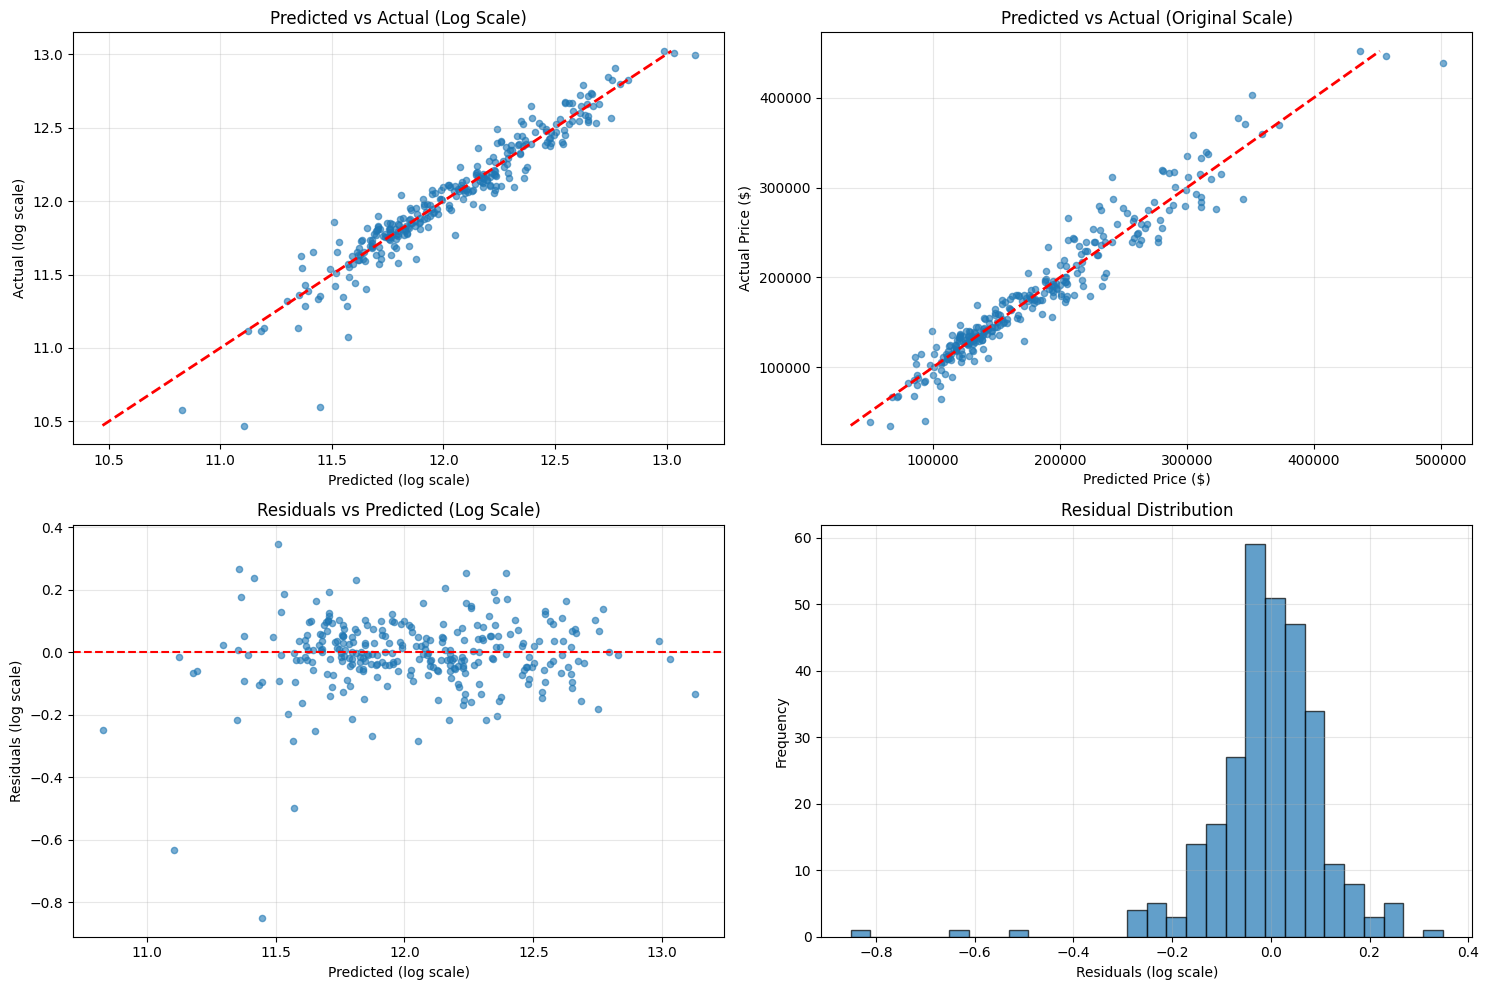

Residual Normality Test: statistic=157.9896, p-value=0.0000
Normal distribution: No
Mean residual: -0.006055
Residual std: 0.1181


In [34]:
print("\nResidual Analysis:")

residuals_log = y_val - val_predictions_log
residuals_original = y_val_original - val_predictions_original

# Create residual plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Predicted vs Actual (log scale)
ax1.scatter(val_predictions_log, y_val, alpha=0.6, s=20)
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax1.set_xlabel('Predicted (log scale)')
ax1.set_ylabel('Actual (log scale)')
ax1.set_title('Predicted vs Actual (Log Scale)')
ax1.grid(True, alpha=0.3)

# Predicted vs Actual (original scale)
ax2.scatter(val_predictions_original, y_val_original, alpha=0.6, s=20)
ax2.plot([y_val_original.min(), y_val_original.max()], 
         [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Price ($)')
ax2.set_ylabel('Actual Price ($)')
ax2.set_title('Predicted vs Actual (Original Scale)')
ax2.grid(True, alpha=0.3)

# Residuals vs Predicted (log scale)
ax3.scatter(val_predictions_log, residuals_log, alpha=0.6, s=20)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted (log scale)')
ax3.set_ylabel('Residuals (log scale)')
ax3.set_title('Residuals vs Predicted (Log Scale)')
ax3.grid(True, alpha=0.3)

# Residual distribution
ax4.hist(residuals_log, bins=30, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Residuals (log scale)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of residuals
from scipy.stats import normaltest

stat, p_value = normaltest(residuals_log)
print(f"Residual Normality Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")
print(f"Mean residual: {residuals_log.mean():.6f}")
print(f"Residual std: {residuals_log.std():.4f}")

In [35]:
print("\nFeature Importance Analysis:")

if hasattr(final_model, 'feature_importances_'):
    # Single model with feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
elif hasattr(final_model, 'fitted_models_'):
    # Ensemble model - average importance from models that have it
    importances = []
    for model in final_model.fitted_models_:
        if hasattr(model, 'feature_importances_'):
            importances.append(model.feature_importances_)
    
    if importances:
        avg_importance = np.mean(importances, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)
    else:
        feature_importance = None
        
elif hasattr(final_model, 'named_estimators_'):
    # Stacking ensemble
    importances = []
    for name, model in final_model.named_estimators_.items():
        if hasattr(model, 'feature_importances_'):
            importances.append(model.feature_importances_)
    
    if importances:
        avg_importance = np.mean(importances, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)
    else:
        feature_importance = None
else:
    feature_importance = None

if feature_importance is not None:
    print("\nTop 15 Most Important Features:")
    print("-" * 40)
    for idx, row in feature_importance.head(15).iterrows():
        feat = row['Feature']
        importance = row['Importance']
        print(f"{feat:<25} {importance:.4f}")
else:
    print("Feature importance not available for this model type")


Feature Importance Analysis:

Top 15 Most Important Features:
----------------------------------------
OverallQual               8.7086
GrLivArea                 5.1246
TotalFlrSF                4.5418
HouseAge                  2.4826
TotalBaths                2.3199
GarageFinish              1.8858
KitchenQual               1.8729
LotArea                   1.7362
BsmtFinSF                 1.5910
Fireplaces                1.2198
YearsSinceRemodel         1.2188
ExterQual                 1.1965
BsmtQual                  1.1079
OverallCond               1.1030
GarageAge                 0.9759


In [36]:
print("\n" + "="*60)
print("GENERATING FINAL TEST PREDICTIONS")
print("="*60)

print("WARNING: First and only time touching test data")

# Fit final model on complete training data
final_model.fit(X_train, y_log)

# Generate predictions on test set
test_predictions_log = final_model.predict(X_test)
test_predictions_original = np.exp(test_predictions_log)

print(f"Test predictions generated: {len(test_predictions_original)} samples")

# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"  Range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}")
print(f"  Mean: ${test_predictions_original.mean():,.0f}")
print(f"  Median: ${np.median(test_predictions_original):,.0f}")
print(f"  Std: ${test_predictions_original.std():,.0f}")

# Sanity checks
print(f"\nSanity Checks:")
negative_count = (test_predictions_original < 0).sum()
low_count = (test_predictions_original < 10000).sum()
high_count = (test_predictions_original > 500000).sum()

print(f"  Negative predictions: {negative_count}")
print(f"  Very low predictions (<$10k): {low_count}")
print(f"  Very high predictions (>$500k): {high_count}")

# Compare with training distribution
train_mean = np.exp(y_log).mean()
test_mean = test_predictions_original.mean()
difference_pct = abs(test_mean - train_mean) / train_mean * 100

print(f"  Training mean: ${train_mean:,.0f}")
print(f"  Test prediction mean: ${test_mean:,.0f}")
print(f"  Difference: {difference_pct:.1f}%")

if difference_pct > 20:
    print("  WARNING: Large difference between train and test means")
else:
    print("  Distribution similarity: Good")


GENERATING FINAL TEST PREDICTIONS
Test predictions generated: 1459 samples

Prediction Statistics:
  Range: $47,499 - $687,685
  Mean: $178,576
  Median: $156,595
  Std: $78,037

Sanity Checks:
  Negative predictions: 0
  Very low predictions (<$10k): 0
  Very high predictions (>$500k): 7
  Training mean: $180,933
  Test prediction mean: $178,576
  Difference: 1.3%
  Distribution similarity: Good


In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_predictions_original)),
    'SalePrice': test_predictions_original
})

# Generate timestamp for unique filename
submission_filename = f'../submissions/submission_{final_model_name}.csv'

# Save submission
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission File Created:")
print(f"  Filename: {submission_filename}")
print(f"  Shape: {submission.shape}")

# Display submission preview
print(f"\nSubmission Preview:")
print(submission.head(10))
print("...")
print(submission.tail(5))

# Validate submission format
print(f"\nSubmission Validation:")
print(f"  IDs start at: {submission['Id'].min()}")
print(f"  IDs end at: {submission['Id'].max()}")
print(f"  ID count: {len(submission)}")
print(f"  Expected count: {len(X_test)}")
print(f"  Format valid: {len(submission) == len(X_test) and submission['Id'].min() == 1461}")


Submission File Created:
  Filename: ../submissions/submission_Simple_Ensemble.csv
  Shape: (1459, 2)

Submission Preview:
     Id      SalePrice
0  1461  117036.522719
1  1462  160093.218825
2  1463  181239.335008
3  1464  193925.411223
4  1465  193252.691224
5  1466  170377.187600
6  1467  170951.443269
7  1468  162280.799416
8  1469  185621.155028
9  1470  119822.490772
...
        Id      SalePrice
1454  2915   84504.700208
1455  2916   82286.803502
1456  2917  159021.976130
1457  2918  116615.189765
1458  2919  212333.416414

Submission Validation:
  IDs start at: 1461
  IDs end at: 2919
  ID count: 1459
  Expected count: 1459
  Format valid: True
